<a href="https://colab.research.google.com/github/Divyanshu-Singh-Chauhan/MEG_BCI-CLassification/blob/main/DeepInsight_U_Essex_hand_vs_feet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, normalize
from keras.utils import np_utils

import sklearn
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from scipy import stats
from scipy.io import loadmat

In [ ]:
from numpy import mean
from numpy import std
from matplotlib import pyplot
import seaborn as sns
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization, SpatialDropout2D
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.constraints import max_norm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

In [ ]:
!pip install git+git://github.com/alok-ai-lab/DeepInsight.git#egg=DeepInsight
from pyDeepInsight import ImageTransformer, LogScaler

  Cloning git://github.com/alok-ai-lab/DeepInsight.git to /tmp/pip-install-reermk56/deepinsight_e7fde5278ab84779a491f91765c17ebe
  Running command git clone -q git://github.com/alok-ai-lab/DeepInsight.git /tmp/pip-install-reermk56/deepinsight_e7fde5278ab84779a491f91765c17ebe
  Created wheel for DeepInsight: filename=DeepInsight-0.1.0-py3-none-any.whl size=17216 sha256=e40b42e514ebeffe9cabc4e1861bb487b0ea6b46947f209ab0daabee06e4fdf2
  Stored in directory: /tmp/pip-ephem-wheel-cache-yzaivn_7/wheels/e4/bc/9d/c483e2a4902573f36c6a2a2e90e247662dada37685d34c1a58
Successfully built DeepInsight


In [ ]:
!wget -O P3_S1.mat https://www.dropbox.com/s/fiy59u74tjxr4bk/ParsedMEGData_P3_S1.mat?dl=0
annots = loadmat('P3_S1.mat')

!wget -O P3_S2.mat https://www.dropbox.com/s/4u48skiijr4h3m4/ParsedMEGData_P3_S2.mat?dl=0
test_annots = loadmat('P3_S2.mat')

--2021-07-31 14:47:56--  https://www.dropbox.com/s/fiy59u74tjxr4bk/ParsedMEGData_P3_S1.mat?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fiy59u74tjxr4bk/ParsedMEGData_P3_S1.mat [following]
--2021-07-31 14:47:57--  https://www.dropbox.com/s/raw/fiy59u74tjxr4bk/ParsedMEGData_P3_S1.mat
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 404 Not Found
2021-07-31 14:47:57 ERROR 404: Not Found.



MatReadError: ignored

### SOME CONTANTS RELATED TO THE DATASET

In [ ]:
fs = 500                  # sampling frequency = 500 Hz
t0 = 2.0                  # Starting Seconds to ignore in the data
t_stamp = int(fs*t0)      # 1250 = fs*t0
label_dict = {1:'Hand',
              2:'Feet',
              3:'Word',
              4:'Math'}

cortex = '(M)'
path = '/content/drive/MyDrive/U_Essex/MEG_Model Weights/DeepInsight_2_CLASSES/test0_alphBeta_H|F_'+ cortex

### UNDERSTANDING THE DATA 

In [ ]:
def data_understand(dicts: dict) -> list:

    """Function for understanding the dataset-->.mat file
    
    :*param* dicts: The dictionary conatining the dataset
    :*returns* processed data and target arrays
    """

    print("1. The keys of the dataset are: ", annots.keys())

    data = np.asarray(annots['MEGdata'][0][0][1])             ### annots['MEGdata'][0][0][1] =  samples per trial * channels * trials
    (s_t, ch, trials) = data.shape
    data = data.reshape(trials, ch, s_t)
    print("2. samples per trial, channels, trials: ", s_t,ch,trials)

    labels = np.asarray(annots['MEGdata'][0][0][2])            ### labels per trial
    print("3. labels shape is: ", labels[0].shape)
        
    cds = annots['MEGdata'][0][0][3]               ### Channel Codes
    codes = []
    for i in range(cds.shape[0]):
      codes.append(cds[i][0][0])
    codes = np.asarray(codes)                      ### array of strings of the channel codes .. eg --> 'MEG0123'
    print("4. Codes shape is: ", codes.shape)

    serial_n = np.asarray(annots['MEGdata'][0][0][4])          ### Channels Serial Number
    print("5. Serial_n shape is: ", serial_n.shape)

    classes_names = np.asarray(annots['MEGdata'][0][0][5])     ### Annotations of classes
    print("6. names of the classes are:", classes_names)  

    return data, labels, codes, serial_n, classes_names



# data, labels, codes, serial_n, classes_names = data_understand(annots)

### DATASET PREPARATION

#### Dataset will need to be prepared with only CLASS 1(hands) and CLASS 2(feet) data in it.

In [ ]:
# Script for removing the first 2.5 seconds data 
def remove_time(X: list)->list:

  """Function for removing the first t0 seconds from the data

  :*param* X: input data array
  :*returns* data with removed elements 
  """
  trials, ch, s_t = X.shape
  l1 = []
  for i in range(trials):
    l2 = []
    for j in range(ch):
      l3 = []
      for k in range(s_t-t_stamp):
        val = X[i][j][t_stamp+k]
        l3.append(val)
      l2.append(l3)
    l1.append(l2)
  return np.asarray(l1)



# X_reduced = remove_time(data)
# print(X_reduced.shape)

In [ ]:
### CHANGE THE LABELS ONLY TO TRAIN A DIFFERENT PAIR
def get_data(labels: list, X: list, class_list: list):

    """Function to get the data for the given two classes

    :label 1 -> Hand
    :Label 2 -> Feet
    :Label 3 -> Word
    :Label 4 -> Math

    :*param* labels: Target labels 
    :*param* X: Contains the input data
    :*param* class_list: contains 2 elements for each class required
    :*returns* binary class data from the dataset
    """
    l1 = class_list[0]
    l2 = class_list[1]

    print("The data being considered is for",label_dict[l1],"vs",label_dict[l2])
    ind1_arr = np.where(labels[0]==l1)
    X1 = []
    for i in ind1_arr[0]:
      X1.append(X[i])
    X1 = np.asarray(X1)
    Y1 = np.zeros(50)

    ind2_arr = np.where(labels[0]==l2)
    X2 = []
    for i in ind2_arr[0]:
      X2.append(X[i])
    X2 = np.asarray(X2)
    Y2 = np.ones(50)

    X = np.concatenate((X1,X2), axis = 0)
    Y = np.concatenate((Y1,Y2), axis = 0)

    return X, Y



# X_binary,Y_binary = get_data(labels, X_reduced, [1,2])
# print(X_binary.shape)
# print(Y_binary.shape)

In [ ]:
def get_encodings(Y: list)->list:

    """Function for transforming target data to one hot encodings

    :*param* Y: Arrays containing target binary labels
    :*returns* transformed one hot encoded array 
    """

    ### CONVERT LABEL OUTPUT TO A ONE HOT ENCODING i.e the shape would be (200,2)
    encoder = LabelEncoder()
    encoder.fit(Y)
    Y = encoder.transform(Y)
    # convert integers to dummy variables (i.e. one hot encoded)
    Y = np_utils.to_categorical(Y)
    return Y



# Y_train = get_encodings(Y_binary)
# print(Y_train.shape)

# STEPS TO FOLLOW #

#### 1. Script for temporal filtering and noise removal --> 4 bands
#### 2. Script for channel selection  --> Motor/frontal/temporal ...
#### 3. EEGNet Model

#### Noise Removal and Temporal Filtering

In [ ]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
def get_band(band: str)->float:

    """Function to get the frequency band

    :*param* band: string denoting the band
    :*returns* the lower and upper bound of frequency
    """
    if band=='alpha':
      lowcut = 8
      highcut = 12
    elif band == 'beta':
      lowcut = 14
      highcut = 30
    elif band == 'mu':
      lowcut = 12
      highcut = 16
    elif band == 'ab':
      lowcut = 8
      highcut = 30
    else:
      lowcut = 0.5
      highcut = 4
    
    return lowcut,highcut
    

def temporal_filtering(data: list, order: int, band = 'ab')->list:

    """Function to perform temporal filtering

    :*param* data: input array to be filtered
    :*param* order: generally kept as 4 for current task
    :*param* band: denoting the band of frequency required
    :*returns* the temporally filtered signal
    """
    lowcut, highcut = get_band(band)
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered = lfilter(b, a, data)
    return filtered


In [ ]:
X_alpha = temporal_filtering(X_binary, 4, band = 'alpha')
X_beta = temporal_filtering(X_binary, 4, band='beta')
X_mu = temporal_filtering(X_binary, 4, band='mu')
X_ab = temporal_filtering(X_binary, 4, band = 'ab')

X_filtered = X_ab
print(X_filtered.shape)

(100, 293, 2500)


### Channel Selection

In [ ]:
### List of all the cortexes by their serial number

MCids= ['064','062','103','041','042','063','104','111','112','044','043','071','072','114','113','181','182','074','073','221','222','183','224']
LTids=['031','011','012','034','032','033','013','021','022','014','151','024','023','154','152','161','162','153','172','164','163']
RTids=['121','124','123','122','141','131','132','144','142','134','133','261','143','262','241','242','264','263','244','243','252']
Fids=['052','081','091','051','053','082','094','092','054','061','101','102','093']
Occids=['184','201','202','223','191','204','203','231','194','192','211','234','232','173','193','212','233','251','174','214','213','254']

In [ ]:
# Script for sorting channels into their cortexes and taking only gradiometers
def get_channels(names: list, grad = True)->dict:

    """Function to get the lists of indexes for channels in each cortex


    :*param* name: array of strings containing codes 
    :*param* grad: bool True signifies that we are taking only gradiometers 
    :*returns* dictionary containing the lists for each cortex
    """
    dicts = {}
    dicts['Motor'] = []
    dicts['Left'] = []
    dicts['Right'] = []
    dicts['Frontal'] = []
    dicts['Occids'] = []
    ls = []
    for i in range(len(names)):
      name = names[i]
      n_code = name[3:7]      # numeric code of the channel
      ids = name[3:6]
      if grad == True:
        if n_code[-1] != '1':
          if ids in MCids:
            dicts['Motor'].append(i)
          elif ids in LTids:
            dicts['Left'].append(i)
          elif ids in RTids:
            dicts['Right'].append(i)
          elif ids in Fids:
            dicts['Frontal'].append(i)
          else:
            dicts['Occids'].append(i)
      
      else:
        if ids in MCids:
          dicts['Motor'].append(i)
        elif ids in LTids:
          dicts['Left'].append(i)
        elif ids in RTids:
          dicts['Right'].append(i)
        elif ids in Fids:
          dicts['Frontal'].append(i)
        else:
          dicts['Occids'].append(i)
        
    return dicts

# this_dict = get_channels(codes, grad = True)
# M_ids = this_dict['Motor']
# L_ids = this_dict['Left']
# R_ids = this_dict['Right']
# F_ids = this_dict['Frontal']
# O_ids = this_dict['Occids']


# print(len(M_ids))
# print(len(L_ids))
# print(len(R_ids))
# print(len(F_ids))
# print(len(O_ids))
# print("Total Gradiometers:", (len(M_ids)+len(L_ids)+len(R_ids)+len(F_ids)+len(O_ids)))

In [ ]:
def remove_channel(X: list, dicts: dict)->list:

  """Function to get the remove the unnecessary channels from the data

  :*param* X: input filtered array
  :*param* dicts: dictionary containing the channel indexes
  :*returns* input array with removed channels
  """

  M_ids = dicts['Motor']
  L_ids = dicts['Left']
  R_ids = dicts['Right']
  F_ids = dicts['Frontal']
  O_ids = dicts['Occids']

  l1 = []
  for i in range(X.shape[0]):
    l2 = []
    for j in (M_ids):                               ### Currently taking Mortex cortex channels
      l3 = []
      for k in range(X.shape[2]):
        val = X[i][j][k]
        l3.append(val)
      l2.append(l3)
    l1.append(l2)
  return np.asarray(l1)

# X_removed = remove_channel(X_filtered, this_dict)
# print(X_removed.shape)

In [ ]:
def min_max_normalized(X: list)->list:

  """Function to get normalized data and an increased dimension at the last axis

  :*param* X: input data array to be normalized
  :*returns normalized input array
  """
  for i in range(X.shape[0]):
    X[i] = normalize(X[i])
  X = np.expand_dims(X, axis=-1)
  return X


def z_score_normalized(X:list)->list:
  """Function to get z-score normalized data at the last axis

  :*param* X: input data array to be z-score normalized
  :*returns* z-score normalized array 
  """
  for i in range(X.shape[0]):
    X[i] = stats.zscore(X[i], axis=1)
  X = np.expand_dims(X,axis=-1)
  return X

# X_train = min_max_normalized(X_removed)
X_train = z_score_normalized(X_removed)
# X_train = min_max_normalized(np.squeeze(X_train, axis=-1))
print(X_train.shape)

In [ ]:
X_train = np.squeeze(X_train, axis = -1)
print(X_train.shape)

In [ ]:
def transform(X:list)->list:
  """
  :*param* X: input array of the signal with shape as (trials, channels, s_trials)
  :*returns* corresponding transformed array to images for each signal with shape as (trials, channels, px, px, 3)  -> (100, 42, 50, 50, 3)
  """

  ln = LogScaler()
  it = ImageTransformer(feature_extractor='tsne', 
                      pixels=50, random_state=1701, 
                      n_jobs=-1)
  n_trials = X.shape[0]
  x_norm = []
  for i in range(n_trials):
    normalized = ln.fit_transform(X[i])
    x_norm.append(it.fit_transform(normalized))
  return np.asarray(x_norm)

X_transformed = transform(X_train)
print(X_transformed.shape)

(100, 42, 50, 50, 3)


In [ ]:
# np.save('/content/drive/MyDrive/U_Essex/transformed_array_test.npy', X_transformed)

train_array = np.load('/content/drive/MyDrive/U_Essex/transformed_array_test_S3.npy')
print("train array shape: ", train_array.shape)       ### --> shape = (trials, channels, px, px, 3) for Subject 9

train array shape:  (100, 42, 50, 50, 3)


In [ ]:
trainX = train_array.reshape(100*42, 50, 50, 3)
print(trainX.shape)

y1 = np.zeros(2100)
y2 = np.ones(2100)
trainY = np.concatenate((y1, y2), axis = 0)
trainY = get_encodings(trainY)
print(trainY.shape)

(4200, 50, 50, 3)
(4200, 2)


### CLASSIFICATION MODEL

In [ ]:
#### CALLBACKS ####


### MODELCHECKPOINT CALLBACK
save = ModelCheckpoint(path+'.h5', verbose=1, save_best_only=True, save_weights_only=True)

### REDUCES LR WHEN METRTIC IS NOT IMPROVING
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta =1e-4, min_lr=0.00001, mode='min')

### LEARNING RATE SCHEDULER
def scheduler(epoch):

  if epoch < 5:
     return 0.001
  else:
     return float(0.001 * tf.math.exp(0.1 * (5 - epoch)))
lr_schedule = LearningRateScheduler(scheduler) 

### EARLY STOPPING
early_stopping = EarlyStopping(monitor = 'val_loss', patience=10, verbose=1)


In [ ]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(50, 50, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(2, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = define_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 100)              

In [ ]:
from sklearn.utils import shuffle
trainX1, trainY1 = shuffle(trainX, trainY)
print(trainX.shape)
print(trainY.shape)

(4200, 50, 50, 3)
(4200, 2)


In [ ]:
trainX1, testX1, trainY1, testY1 = train_test_split(trainX, trainY, test_size=0.75, random_state=42)

In [ ]:
results = model.fit(trainX1, trainY1, epochs=100, batch_size=32, validation_data=(testX1, testY1), verbose=1, callbacks = [lr_schedule, early_stopping])

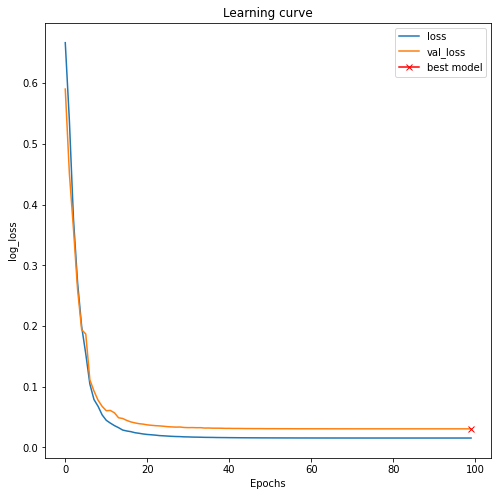

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
plt.savefig(path+'.png', bbox_inches='tight')

AUC: 0.998


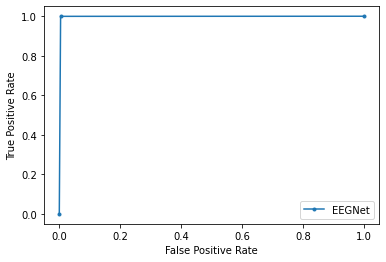

In [ ]:
def plot_roc_curve(Y_predicted: list, Y_actual: list):
    """Function to plot the ROC curve and give AUC value

    :*param* Y_predict: predicted model output in float values
    :*param* Y_actual: actual labels
    :*returns* the ROC plot and AUC values
    """
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_actual.argmax(axis=1), Y_predicted.argmax(axis=1))

    # calculate AUC
    auc = roc_auc_score(Y_actual.argmax(axis=1), Y_predicted.argmax(axis=1))
    print('AUC: %.3f' % auc)

    plt.plot(fpr, tpr, marker='.', label='EEGNet')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.savefig(path+'_ROC-AUC.png', bbox_inches='tight')
    plt.show()

probs = model.predict(trainX)
plot_roc_curve(probs, trainY)

# Visualization  

### 1. Hand vs Feet

In [ ]:
ln = LogScaler()
# for i in range(X_train.shape[0]):
X = X_train[0]
X_train_norm = ln.fit_transform(X)


it = ImageTransformer(feature_extractor='tsne', 
                      pixels=50, random_state=1701, 
                      n_jobs=-1)

plt.figure(figsize=(5, 5))
it.fit(X_train_norm, plot=True)

In [ ]:
print(X_train_norm.shape)
print(Y_train[0])

In [ ]:
mat_train_hand = it.fit_transform(X_train_norm)

(42, 50, 50, 3)


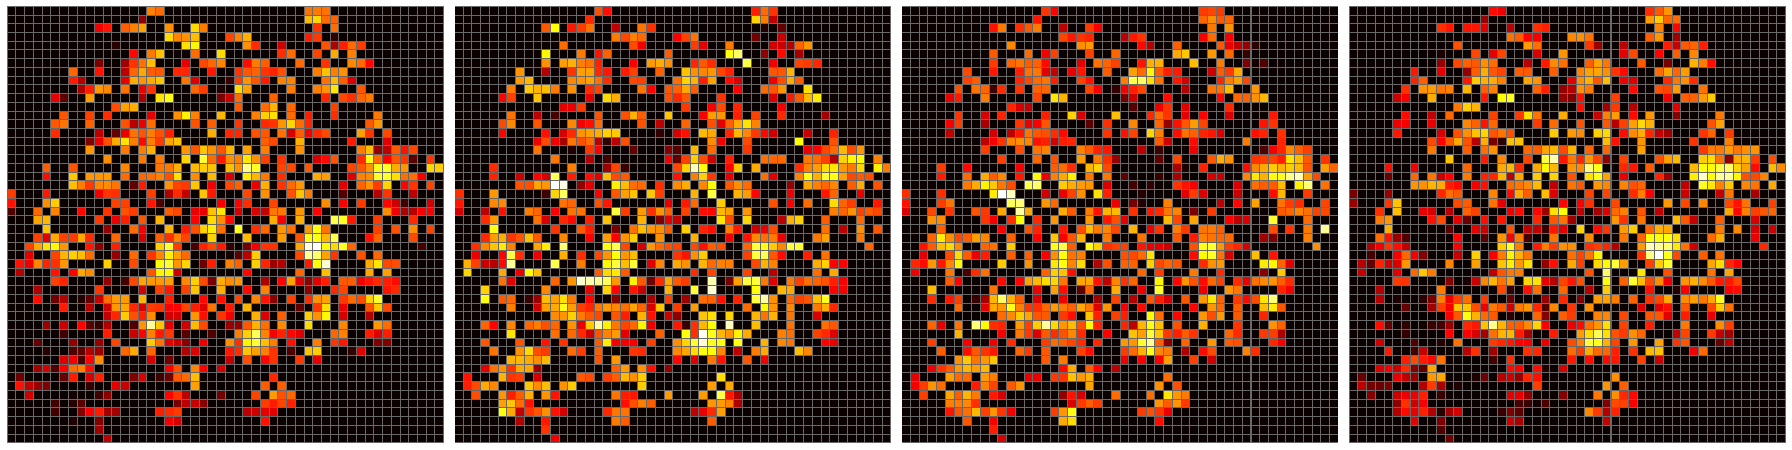

In [ ]:
print(mat_train_hand.shape)
fig, ax = plt.subplots(1, 4, figsize=(25, 7))
for i in range(0,4):
    gray = mat_train_hand[i][:,:,0]
    cax = sns.heatmap(gray, cmap='hot',
                      linewidth=0.01, linecolor='dimgrey',
                      square=True, ax=ax[i], cbar=False)
    cax.axis('off')
plt.tight_layout()

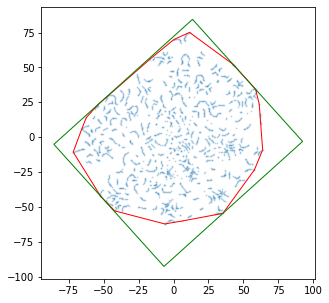

In [ ]:
ln = LogScaler()
# for i in range(X_train.shape[0]):
X = X_train[50]
X_train_norm = ln.fit_transform(X)

it = ImageTransformer(feature_extractor='tsne', 
                      pixels=50, random_state=1701, 
                      n_jobs=-1)

plt.figure(figsize=(5, 5))
it.fit(X_train_norm, plot=True)

(42, 50, 50, 3)


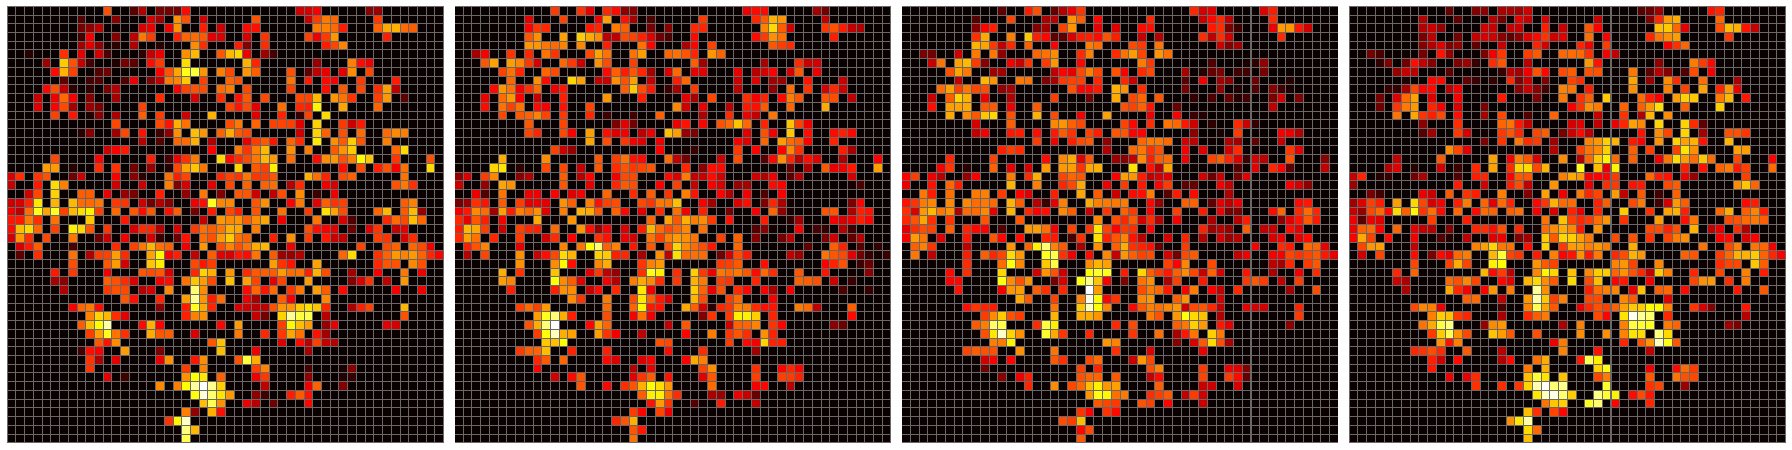

In [ ]:
mat_train_feet = it.fit_transform(X_train_norm)
print(mat_train_feet.shape)
fig, ax = plt.subplots(1, 4, figsize=(25, 7))
for i in range(0,4):
    gray = mat_train_feet[i][:,:,0]
    cax = sns.heatmap(gray, cmap='hot',
                      linewidth=0.01, linecolor='dimgrey',
                      square=True, ax=ax[i], cbar=False)
    cax.axis('off')
plt.tight_layout()

In [ ]:
print(Y_train[50])

[0. 1.]


(2500,)


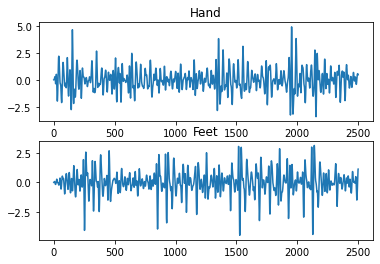

In [ ]:
def visualize(X_hand:list, X_feet:list):
  x = np.linspace(0,2500,2500)
  print(x.shape)
  fig, (ax1, ax2) = plt.subplots(2)
  # fig.suptitle('Horizontally stacked subplots')
  ax1.plot(x, X_hand)
  ax1.set_title("Hand")
  ax2.plot(x, X_feet)
  ax2.set_title("Feet")

visualize(X_train[5][0], X_train[80][0])

### 2. Train Hand vs Test Hand

In [ ]:
X_test = np.load('/content/drive/MyDrive/U_Essex/transformed_array_test_S3.npy')
X_train = np.load('/content/drive/MyDrive/U_Essex/transformed_array_S3.npy')

In [ ]:
print(X_test.shape)
print(X_train.shape)


def plot(X: list, string: str):

    fig, ax = plt.subplots(1, 4, figsize=(15, 4))
    fig.suptitle(string)
    for i in range(0,4):
        gray = X[i+20][:,:,0]
        cax = sns.heatmap(gray, cmap='hot',
                          linewidth=0.01, linecolor='dimgrey',
                          square=True, ax=ax[i], cbar=False)
        cax.axis('off')
    plt.tight_layout()

(100, 42, 50, 50, 3)
(100, 42, 50, 50, 3)


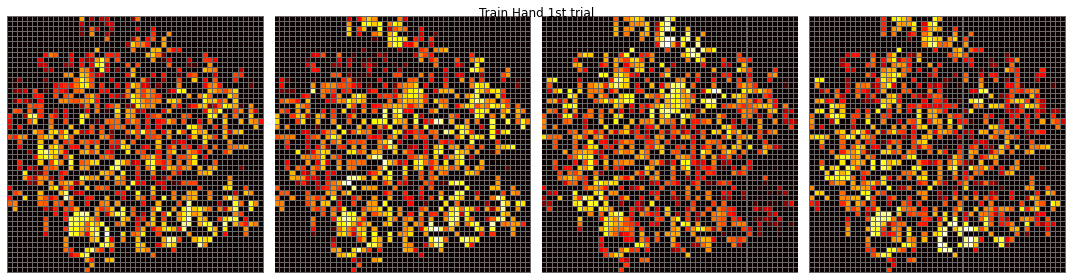

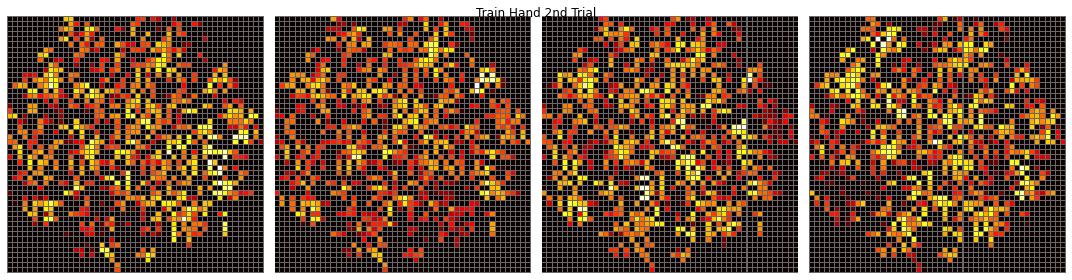

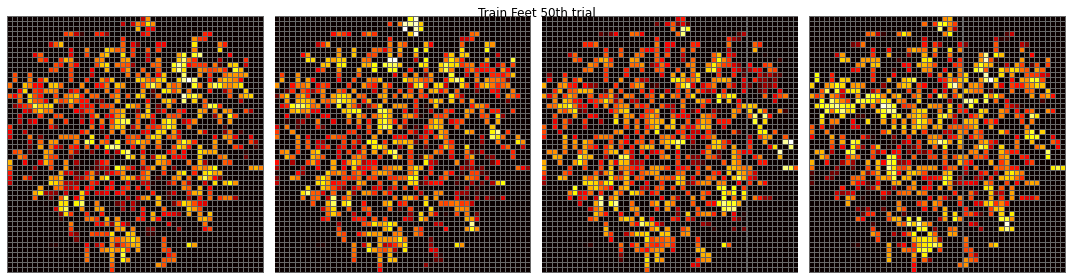

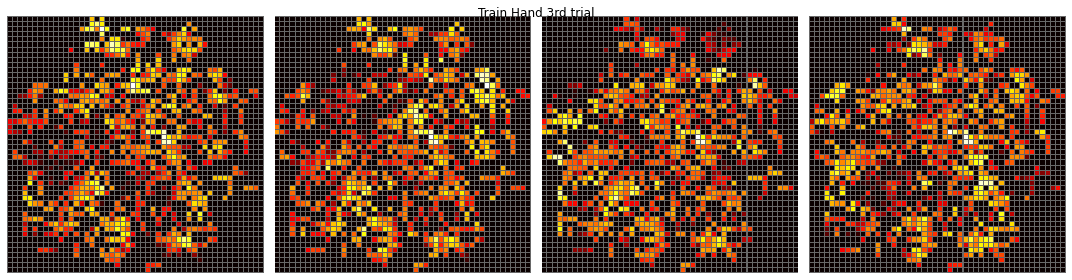

In [ ]:
plot(X_train[0], 'Train Hand 1st trial')
plot(X_train[1], 'Train Hand 2nd Trial')
plot(X_train[50], 'Train Feet 50th trial')
plot(X_train[3], 'Train Hand 3rd trial')

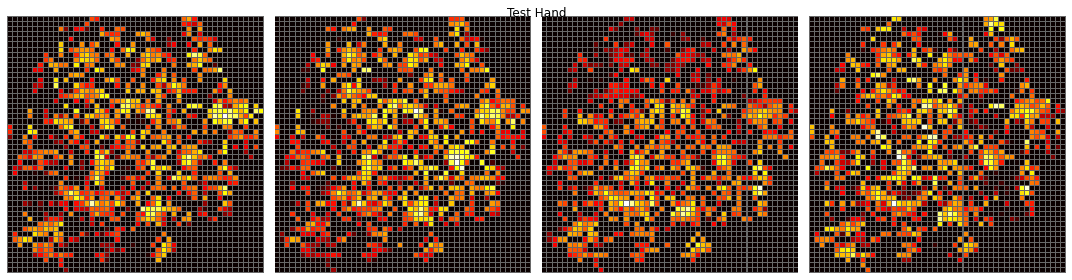

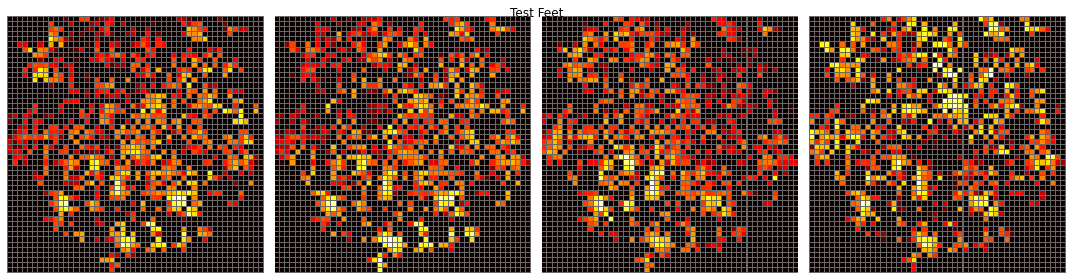

In [ ]:
plot(X_test[0], 'Test Hand')
plot(X_test[50], 'Test Feet')

In [ ]:
## Finding the most similar channel for each channel in training set ... 

x1 = np.sum(X_train, axis = 4)[0]
x2 = np.sum(X_test, axis = 4)[0]
dicts = {}
for i in range(x1.shape[0]):
  img1 = x1[i]
  for j in range(x2.shape[0]):
    diff = 

    



### TEST DATA EVALUATION

132/132 [==============================] - 3s 23ms/step - loss: 1.4771 - accuracy: 0.4776
Test loss: 1.4771407842636108
Test accuracy: 0.4776190519332886
Accuracy Score:  0.4776190476190476
AUC: 0.478


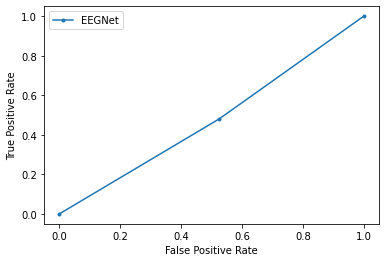

In [ ]:
def prep_data():

  X_test = np.load('/content/drive/MyDrive/U_Essex/transformed_array_S3.npy')
  X_test = X_test.reshape(100*42, 50, 50, 3)
  y1 = np.zeros(2100)
  y2 = np.ones(2100)
  Y_test = np.concatenate((y1, y2), axis = 0)
  Y_test = get_encodings(Y_test) 

  return X_test, Y_test



def eval(X, Y):

    score = model.evaluate(X, Y, verbose = 1) 

    print('Test loss:', score[0]) 
    print('Test accuracy:', score[1])

    from sklearn.metrics import accuracy_score

    probs = model.predict(X)
    print('Accuracy Score: ',accuracy_score(Y.argmax(axis=1), probs.argmax(axis=1)))
    plot_roc_curve(probs, Y)

X_test, Y_test = prep_data()
eval(X_test, Y_test)